In [37]:
import torch
from peft import LoraConfig, get_peft_model
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import os
from PIL import Image
from dataloader import PairedDataset
from model import NST
from lossnet import VGG
from trainer import train_NST, make_grid
from encoder import print_trainable_parameters

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else 'cpu')
torch.manual_seed(324)
torch.cuda.manual_seed(324)
np.random.seed(324)
random.seed(324)
# dataloader
content_dir = "/data/louis/NST_dataset/COCO2014/"
style_dir = "/data/louis/NST_dataset/WikiArt_processed/"
train_dataset = PairedDataset(content_dir, style_dir, crop = False, norm = True, mode='train')
val_dataset = PairedDataset(content_dir, style_dir, crop = False, norm = True, mode='val')
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
# lora config
lora_config_c = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
)
lora_config_s = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
)

In [3]:
model = NST(encoder_num_layers=6, decoder_num_layers=3, freeze=True)
model.encoder_c = get_peft_model(model.encoder_c, lora_config_c)
model.encoder_s = get_peft_model(model.encoder_s, lora_config_s)
model.load_state_dict(torch.load("/data/louis/NST_checkpoint/NST_23th_jointly_training_best.pth", map_location=device))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


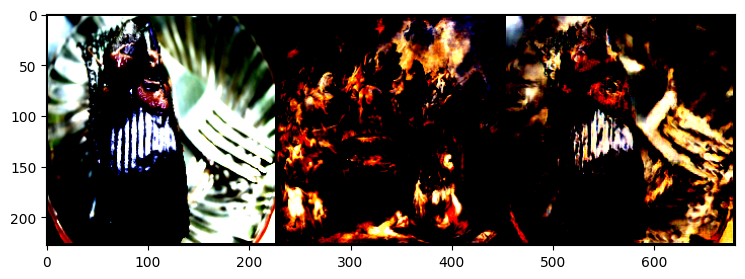

In [5]:
model.eval()
with torch.no_grad():
    contents, styles = next(iter(val_dataloader))
    gens = model(contents, styles)
    imag_stack = torch.vstack([contents, styles, gens])
    imag_grid = make_grid(imag_stack, nrow=3)
    plt.figure(figsize=(10,3))
    plt.imshow(imag_grid.permute(1,2,0))

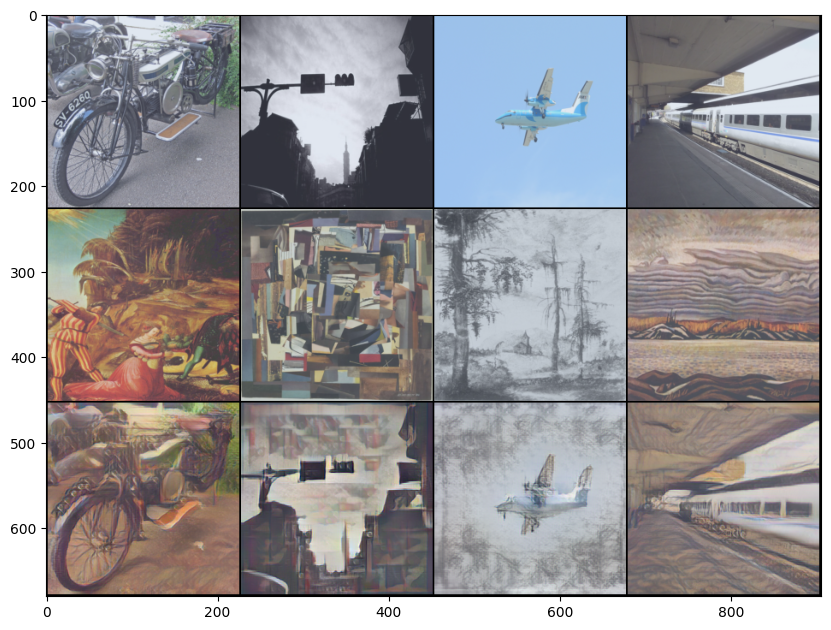

In [104]:
from torchvision.transforms import transforms
from PIL import Image
transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

paths_c = [
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000000073.jpg',
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000000359.jpg',
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000213412.jpg',
    '/data/louis/NST_dataset/COCO2014/val/COCO_val2014_000000352491.jpg'
]

paths_s = [
    '/data/louis/NST_dataset/WikiArt_processed/val/albrecht-altdorfer_beheading-of-st-catherine-1506.jpg',
    '/data/louis/NST_dataset/WikiArt_processed/val/ad-reinhardt_collage-1940.jpg', 
    '/data/louis/NST_dataset/WikiArt_processed/val/albrecht-altdorfer_alpine-landscape-with-church-1522.jpg',
    '/data/louis/NST_dataset/WikiArt_processed/val/a.y.-jackson_algoma-in-november-1935.jpg'
]

def val_selected_images(model, paths_c, paths_s, transform):
    contents = []
    styles = []
    num_selected = len(paths_c)
    for file_c, file_s in zip(paths_c, paths_s):
        content_imag = Image.open(file_c).convert("RGB")
        Ic = transform(content_imag)
        contents.append(Ic)
        style_imag = Image.open(file_s).convert("RGB")
        Is = transform(style_imag)
        styles.append(Is)
    contents = torch.stack(contents, dim=0)
    styles = torch.stack(styles, dim=0)
    gens = model(contents, styles)
    img_stack = torch.vstack([contents, styles, gens])
    img_grid = make_grid(img_stack, normalize=True, nrow=num_selected)
    # writer.add_image(
    #     "Contents/Styles/Generated", img_grid, global_step=val_step
    # )
    return img_grid

imag_grid = val_selected_images(model, paths_c=paths_c, paths_s=paths_s, transform=transform)
plt.figure(figsize=(10,10))
plt.imshow(imag_grid.permute(1,2,0))

In [32]:
from torch import nn
def inference(model, content_path, style_path, device):
    # load images
    content_imag = transforms.ToTensor()(Image.open(content_path).convert("RGB"))
    style_imag = transforms.ToTensor()(Image.open(style_path).convert("RGB"))
    # calculate input standard size, since the input should be square images and size should be a multiple of 16
    _, Hc, Wc = content_imag.shape
    style_imag_resize = transforms.Resize((Hc, Wc))(style_imag)
    size = max(Hc, Wc)
    if size % 16 != 0:
        std_size = size + (16 - size % 16)
    else:
        std_size = size
    pad_H = std_size - Hc
    pad_W = std_size - Wc
    # pad the images
    Ic = nn.ReflectionPad2d([0, pad_W, 0, pad_H])(content_imag).unsqueeze(0).to(device)
    Is = nn.ReflectionPad2d([0, pad_W, 0, pad_H])(style_imag_resize).unsqueeze(0).to(device)
    # normalize
    normalize = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    Ic = normalize(Ic)
    Is = normalize(Is)
    # generate images
    model.eval()
    with torch.no_grad():
        Ig = model(Ic, Is)
    # crop the generated images to be of the same size as content_imag
    if pad_H == 0 and pad_W == 0:
        gen_imag = Ig
    elif pad_H == 0 and pad_W != 0:
        gen_imag = Ig[:,:,:,:-pad_W]
    elif pad_H != 0 and pad_W == 0:
        gen_imag = Ig[:,:,:-pad_H]
    else:
        gen_imag = Ig[:,:,:-pad_H, :-pad_W]
    # visualize
    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.imshow(content_imag.permute(1,2,0))
    plt.subplot(1,3,2)
    plt.imshow(style_imag.permute(1,2,0))
    plt.subplot(1,3,3)
    plt.imshow(gen_imag.squeeze(0).cpu().permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


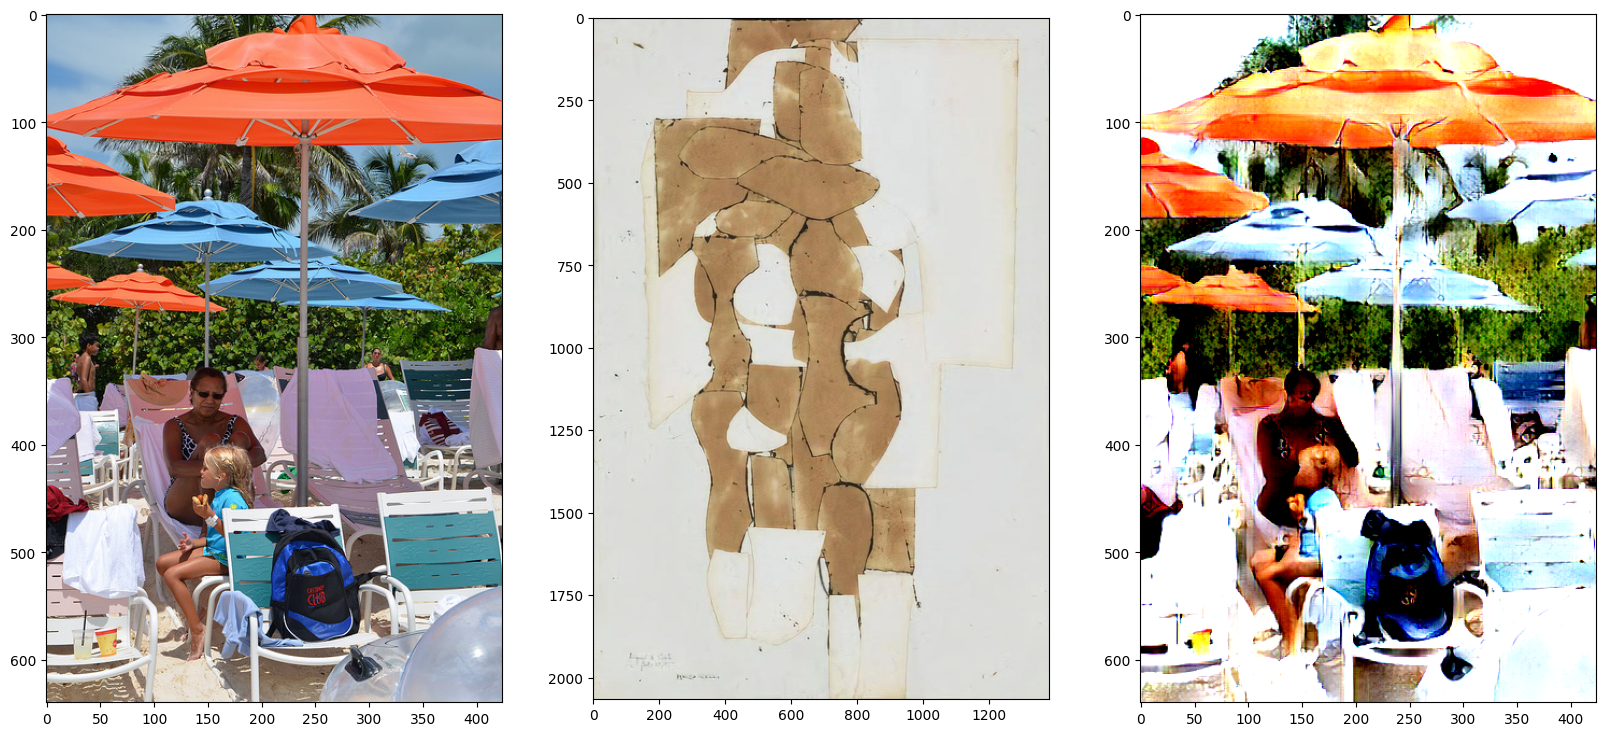

In [225]:
root_c = '/data/louis/NST_dataset/COCO2014/val'
root_s = '/data/louis/NST_dataset/WikiArt_processed/val'
files_c = os.listdir(root_c)
files_s = os.listdir(root_s)
idx_c = np.random.randint(0, len(files_c))
idx_s = np.random.randint(0, len(files_s))
path_c = os.path.join(root_c, files_c[idx_c])
path_s = os.path.join(root_s, files_s[idx_s])
device = 'cuda:0'
inference(model, path_c, path_s, device)